# Business Problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

1. Your analysis should yield three concrete business recommendations. The ultimate purpose of exploratory analysis is not just to learn about the data, but to help an organization perform better. Explicitly relate your findings to business needs by recommending actions that you think the business should take.

2. Communicating about your work well is extremely important. Your ability to provide value to an organization - or to land a job there - is directly reliant on your ability to communicate with them about what you have done and why it is valuable. Create a storyline your audience (the head of the new movie studio) can follow by walking them through the steps of your process, highlighting the most important points and skipping over the rest.

3. Use plenty of visualizations. Visualizations are invaluable for exploring your data and making your findings accessible to a non-technical audience. Spotlight visuals in your presentation, but only ones that relate directly to your recommendations. Simple visuals are usually best (e.g. bar charts and line graphs), and don't forget to format them well (e.g. labels, titles).

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from cycler import cycler

In [2]:
n_colors = 30
viridis_colors = plt.cm.viridis(np.linspace(0, 1, n_colors))

sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['axes.prop_cycle'] = cycler(color=viridis_colors)
sns.set_palette('viridis')

In [3]:
conn = sqlite3.Connection("../Data/im.db")
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cur.fetchall()

imdb = {}

for table in table_names:
    table_name = table[0]
    imdb[table_name] = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

In [5]:
rt_reviews_df = pd.read_csv("../Data/rt.reviews.tsv",delimiter='\t', encoding='latin1')
rt_movie_info_df = pd.read_csv("../Data/rt.movie_info.tsv",delimiter='\t')

## IMDB Table Cleaning

In [6]:
for name, df in imdb.items():
    display(f'{name}: {df.columns.to_list()}')

"movie_basics: ['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']"

"directors: ['movie_id', 'person_id']"

"known_for: ['person_id', 'movie_id']"

"movie_akas: ['movie_id', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'is_original_title']"

"movie_ratings: ['movie_id', 'averagerating', 'numvotes']"

"persons: ['person_id', 'primary_name', 'birth_year', 'death_year', 'primary_profession']"

"principals: ['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters']"

"writers: ['movie_id', 'person_id']"

In [7]:
def select_title(row):
    if row['is_original_title'] == 1.0:
        return row['original_title']
    else:
        return row['primary_title']
    
directors_with_names = pd.merge(imdb['directors'], imdb['persons'], on='person_id', how='inner').drop_duplicates(subset=['person_id'])
directors_with_names = directors_with_names[['primary_name', 'movie_id']]
directors_with_names.head()    

imdb_df = pd.merge(imdb['movie_akas'], imdb['movie_basics'], how='inner')
imdb_df['title'] = imdb_df.apply(select_title, axis=1)
imdb_df = imdb_df.drop(columns=['primary_title', 'original_title', 'is_original_title'])

imdb_df = pd.merge(imdb['movie_ratings'], imdb_df, how='inner')
imdb_df = imdb_df.drop(columns=['language', 'types', 'attributes'])
imdb_df = imdb_df.dropna(subset=['region', 'runtime_minutes', 'genres'])
imdb_df = pd.merge(imdb_df, directors_with_names, on='movie_id', how='inner')
imdb_df = imdb_df.drop_duplicates(subset=['movie_id']).drop_duplicates(subset=['title'])
imdb_df = imdb_df.set_index('title').sort_index()
imdb_df = imdb_df.rename(columns={'primary_name': 'directors'})

In [8]:
imdb_df.isnull().sum()

movie_id           0
averagerating      0
numvotes           0
ordering           0
region             0
start_year         0
runtime_minutes    0
genres             0
directors          0
dtype: int64

In [10]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36485 entries, !Women Art Revolution to à propos: philosophie
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         36485 non-null  object 
 1   averagerating    36485 non-null  float64
 2   numvotes         36485 non-null  int64  
 3   ordering         36485 non-null  int64  
 4   region           36485 non-null  object 
 5   start_year       36485 non-null  int64  
 6   runtime_minutes  36485 non-null  float64
 7   genres           36485 non-null  object 
 8   directors        36485 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 2.8+ MB


## Movie Budgets Table Cleaning

In [12]:
movie_budgets_df = pd.read_csv("../Data/tn.movie_budgets.csv")

def format_numbers(number):
    number = str(number).strip()
    number = str(number).replace('$', '').replace(',', '')
    return float(number)

for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    movie_budgets_df[col] = movie_budgets_df[col].apply(format_numbers)

movie_budgets_df['foreign_gross'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['domestic_gross']
movie_budgets_df['profit'] = (movie_budgets_df['domestic_gross'] + movie_budgets_df['foreign_gross']) - movie_budgets_df['production_budget']
movie_budgets_df = movie_budgets_df.drop(columns=['worldwide_gross'])
movie_budgets_df = movie_budgets_df.rename(columns={'movie': 'title'})
movie_budgets_df = movie_budgets_df.drop_duplicates(subset=['title'])
movie_budgets_df = movie_budgets_df.set_index('title').sort_index()

In [13]:
movie_budgets_df.isnull().sum()

id                   0
release_date         0
production_budget    0
domestic_gross       0
foreign_gross        0
profit               0
dtype: int64

In [14]:
movie_budgets_df.head()

,id,release_date,production_budget,domestic_gross,foreign_gross,profit
title,,,,,,
#Horror,16,"Nov 20, 2015",1500000.0,0.0,0.0,-1500000.0
(500) Days of Summer,55,"Jul 17, 2009",7500000.0,32425665.0,2013395.0,26939060.0
10 Cloverfield Lane,54,"Mar 11, 2016",5000000.0,72082999.0,36203423.0,103286422.0
10 Days in a Madhouse,48,"Nov 11, 2015",12000000.0,14616.0,0.0,-11985384.0
10 Things I Hate About You,63,"Mar 31, 1999",13000000.0,38177966.0,22235984.0,47413950.0


## TMDB Movies Table Cleaning

In [15]:
tmdb_movies_df = pd.read_csv("../Data/tmdb.movies.csv")

tmdb_movies_df = tmdb_movies_df.filter(['title', 'popularity', 'vote_count', 'genre_ids'])
tmdb_movies_df = tmdb_movies_df.drop_duplicates(subset=['title'])
tmdb_movies_df = tmdb_movies_df.set_index('title').sort_index()
tmdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24688 entries, "BLESSED" to 해양경찰 마르코
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   popularity  24688 non-null  float64
 1   vote_count  24688 non-null  int64  
 2   genre_ids   24688 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 771.5+ KB


In [227]:
tmdb_movies_df.head()

,popularity,vote_count,genre_ids
title,,,
"""BLESSED""",0.600,1,"[99, 12]"
"""Legitimate Rape"" Pharmaceutical Ad",0.600,2,"[35, 80]"
"""cherry"" - Supreme",0.893,1,[99]
#1 Cheerleader Camp,3.277,34,"[35, 18]"
#ALLMYMOVIES,0.840,4,[99]


## Movie Gross Table Cleaning

In [228]:
movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

for col in ['domestic_gross', 'foreign_gross']:
    movie_gross_df[col] = movie_gross_df[col].apply(format_numbers)

movie_gross_df = movie_gross_df.drop_duplicates(subset=['title']).dropna(subset=['foreign_gross'])
movie_gross_df['total_gross'] = movie_gross_df['domestic_gross'] + movie_gross_df['foreign_gross']
movie_gross_df = movie_gross_df.dropna()
movie_gross_df = movie_gross_df.set_index('title').sort_index()
movie_gross_df = movie_gross_df[['year', 'studio', 'domestic_gross', 'foreign_gross', 'total_gross']]
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, '71 to xXx: The Return of Xander Cage
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            2007 non-null   int64  
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   float64
 4   total_gross     2007 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 94.1+ KB


In [229]:
movie_gross_df.head()

,year,studio,domestic_gross,foreign_gross,total_gross
title,,,,,
'71,2015,RAtt.,1300000.0,355000.0,1655000.0
10 Cloverfield Lane,2016,Par.,72100000.0,38100000.0,110200000.0
102 Not Out,2018,Sony,1300000.0,10900000.0,12200000.0
11-11-11,2011,Rocket,32800.0,5700000.0,5732800.0
12 Strong,2018,WB,45800000.0,21600000.0,67400000.0


## Merging Tables

In [230]:
merged_df = pd.merge(imdb_df, movie_budgets_df, on='title', how='inner')
merged_df['genres'] = merged_df['genres'].apply(lambda x: x.split(','))
merged_df['genres_numeric'] = merged_df['genres'].apply(tuple).factorize()[0]
merged_df = merged_df.rename(columns={'start_year': 'year'}).drop(columns='release_date')

In [231]:
start_date = merged_df['year'].min()
end_date = merged_df['year'].max()

In [444]:
def plot_top_n(df, groupby_column, n, start_date, end_date):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    top_by_mean_profit = df.groupby(groupby_column).mean()['profit'].sort_values(ascending=False)[:n]
    top_by_mean_profit = top_by_mean_profit / top_by_mean_profit.sum()

    top_by_mean_profit.plot.pie(ax=axes[0], normalize=True, 
                               autopct='%.1f%%', legend=False,  
                               wedgeprops=dict(edgecolor='none'))
    axes[0].set_title(f'Top {n} {groupby_column.capitalize()} By Average Profit\n({start_date} - {end_date})')
    axes[0].set_ylabel('')

    top_by_total_profit = df.groupby(groupby_column).sum()['profit'].sort_values(ascending=False)[:n]
    top_by_total_profit = top_by_total_profit / top_by_total_profit.sum()

    top_by_total_profit.plot.pie(ax=axes[1], normalize=True, 
                                autopct='%.1f%%', legend=False,  
                                wedgeprops=dict(edgecolor='none'))
    axes[1].set_title(f'Top {n} {groupby_column.capitalize()} By Total Profit\n({start_date} - {end_date})')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

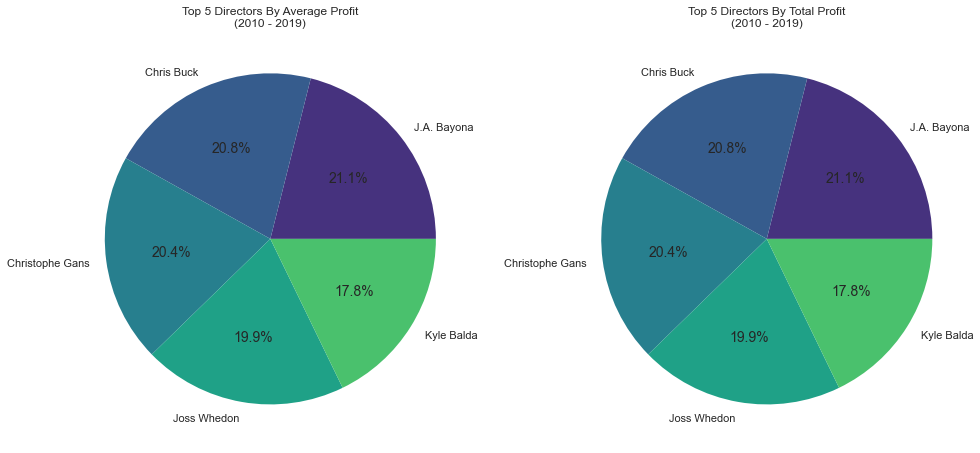

In [456]:
plot_top_n(merged_df, 'directors', 5, start_date, end_date)

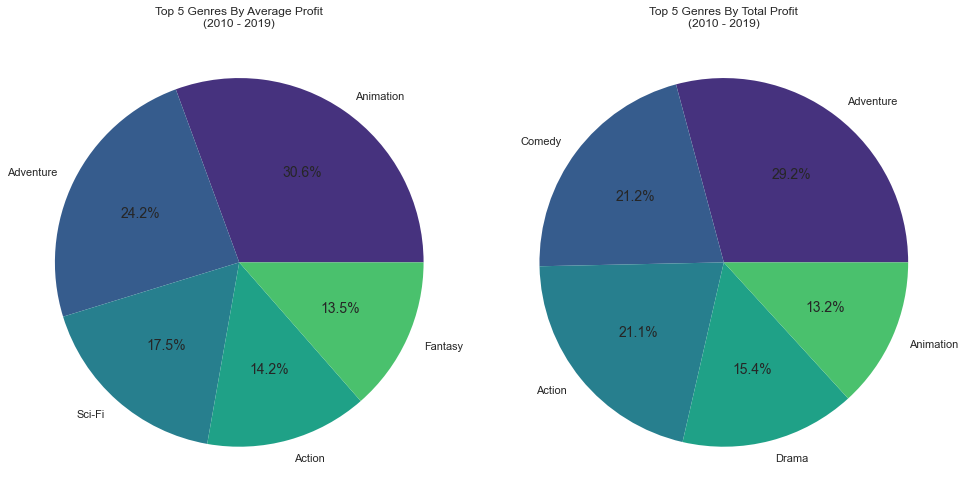

In [415]:
merged_df_genres_unique = merged_df.explode(column='genres')
plot_top_n(merged_df_genres_unique, 'genres', 5, start_date, end_date)

## Regressions

$$y = \beta{x} + \alpha + \epsilon$$

In [427]:
budget_profit_regression_df = merged_df[['production_budget', 'profit']]
budget_profit_regression_df.head()

,production_budget,profit
title,,
#Horror,1500000.0,-1500000.0
10 Cloverfield Lane,5000000.0,103286422.0
12 Strong,35000000.0,36118378.0
12 Years a Slave,20000000.0,161025343.0
13 Sins,4000000.0,-3952448.0


### Regression on scaled data:

In [326]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(budget_profit_regression_df)
X_S = scaled_data[:, 0].reshape(-1, 1)
y_S = scaled_data[:, 1].reshape(-1, 1)

In [330]:
import statsmodels.api as sm

lin_reg = sm.OLS(y_S, X_S).fit()

print(f'profit change per one standard deviation increase in budget: {lin_reg.params[0]:,.2f}')

profit change per one standard deviation increase in budget: 0.64


In [333]:
print(lin_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.414
Model:                            OLS   Adj. R-squared (uncentered):              0.414
Method:                 Least Squares   F-statistic:                              799.8
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   1.64e-133
Time:                        16:45:25   Log-Likelihood:                         -1303.5
No. Observations:                1132   AIC:                                      2609.
Df Residuals:                    1131   BIC:                                      2614.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Regression on unscaled data:

In [339]:
X = budget_profit_regression_df['production_budget'].values.reshape(-1, 1)
y = budget_profit_regression_df['profit'].values.reshape(-1, 1)

lin_reg2 = sm.OLS(y, X).fit()

print(f'profit change one dollar increase in budget: {lin_reg2.params[0]:,.2f}')

profit change one dollar increase in budget: 1.88


In [406]:
print(lin_reg2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.492
Model:                            OLS   Adj. R-squared (uncentered):              0.492
Method:                 Least Squares   F-statistic:                              1097.
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   1.05e-168
Time:                        17:01:20   Log-Likelihood:                         -22585.
No. Observations:                1132   AIC:                                  4.517e+04
Df Residuals:                    1131   BIC:                                  4.518e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

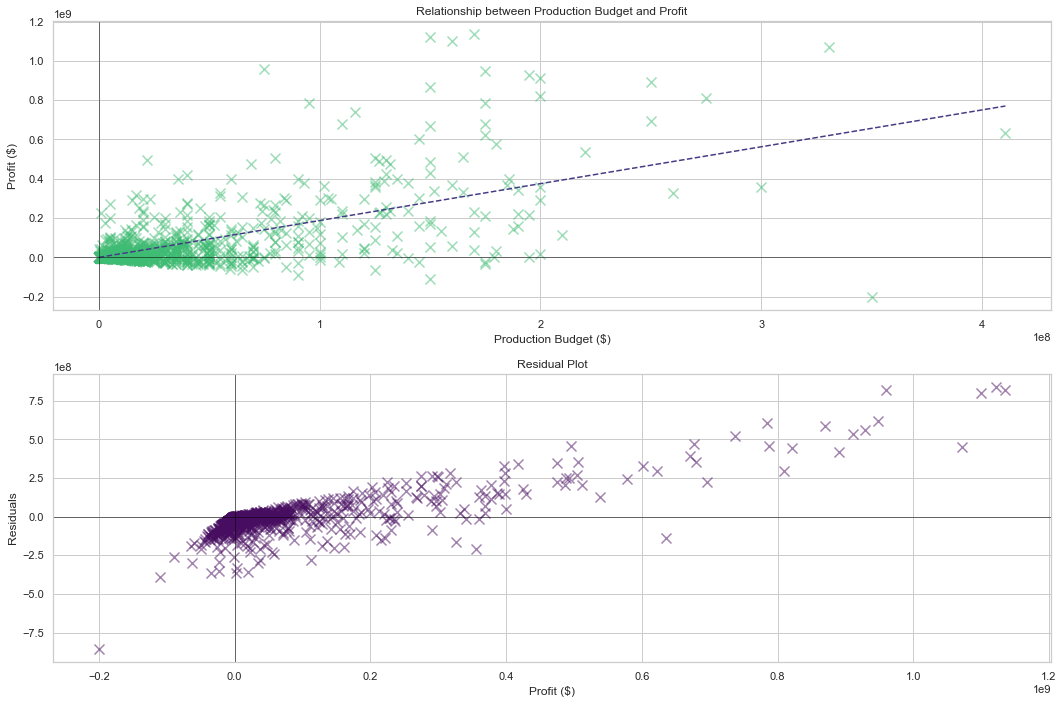

In [425]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

axes[0].scatter(X, y, s=100, marker='x', alpha=.5, color=viridis_colors[20])
x_line = np.linspace(X.min(), X.max())
y_line = x_line * lin_reg2.params[0]
axes[0].plot(x_line, y_line, color=viridis_colors[5], linestyle='--')
axes[0].axvline(0, color='k', linewidth=.5)
axes[0].axhline(0, color='k', linewidth=.5)
axes[0].set_xlabel('Production Budget ($)')
axes[0].set_ylabel('Profit ($)')
axes[0].set_title("Relationship between Production Budget and Profit")

y_pred = lin_reg2.predict(X)
residuals = (y.reshape(-1, 1) - y_pred.reshape(-1, 1))
axes[1].scatter(y, residuals, s=100, marker='x', color=viridis_colors[1], alpha=0.5)
axes[1].axvline(0, color='k', linewidth=.5)
axes[1].axhline(0, color='k', linewidth=.5)
axes[1].set_xlabel('Profit ($)')
axes[1].set_ylabel('Residuals')
axes[1].set_title("Residual Plot")

plt.tight_layout()
plt.show()

In [443]:
merged_df.groupby('directors').sum()['numvotes'].sort_values(ascending=False)

directors
Christopher Nolan    1387769
Martin Scorsese      1035358
Joss Whedon           665594
Sam Mendes            592221
Anthony Russo         583507
                      ...   
D. Tattersall              5
Ira Farmer                 5
Patrick Epape              5
Nic Good                   5
Hatef Alimardani           5
Name: numvotes, Length: 1131, dtype: int64

## Findings

### <u>Finding 1</u>:

Top 5 Most Profitable Directors (both by average and total profit):
1. J.A. Bayona
2. Chris Buck
3. Christophe Gans
4. Joss Whedon
5. Kyle Balda


### <u>Finding 2</u>:

Top 5 Most Profitable Unique Genres (by average profit):

1. Animation
2. Adventure
3. Sci-Fi
4. Action
5. Fantasy

Top 5 Most Profitable Unique Genres (by total profit):

1. Adventure
2. Comedy < Action
4. Drama
5. Animation

### <u>Finding 3</u>:

1. $\text{Profit} = 1.88 \times \text{Production Budget}$
2. $\rho_{_{\text{budget, profit}}} = 0.64$ — high correlation!

###